In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
data_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv"
audio_data = pd.read_csv(data_path)

In [14]:
label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])
     
audio_data.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,0
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,0
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,0
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,0
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,0


In [15]:
y = audio_data['LABEL']
X = audio_data.drop('LABEL', axis = 1)

In [16]:
X.columns

Index(['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20'],
      dtype='object')

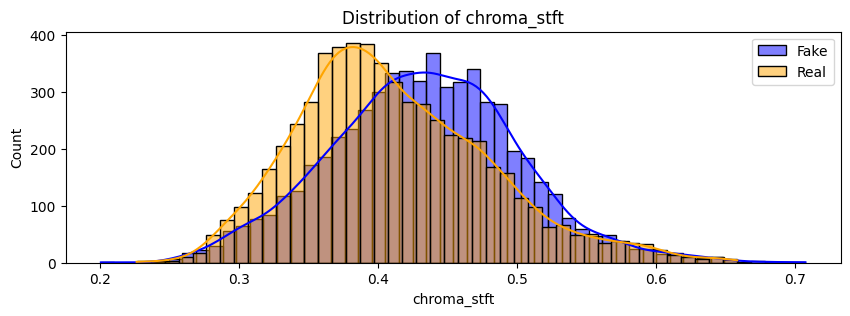

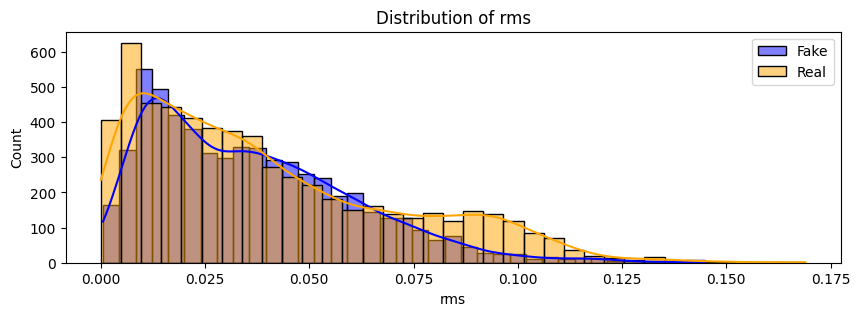

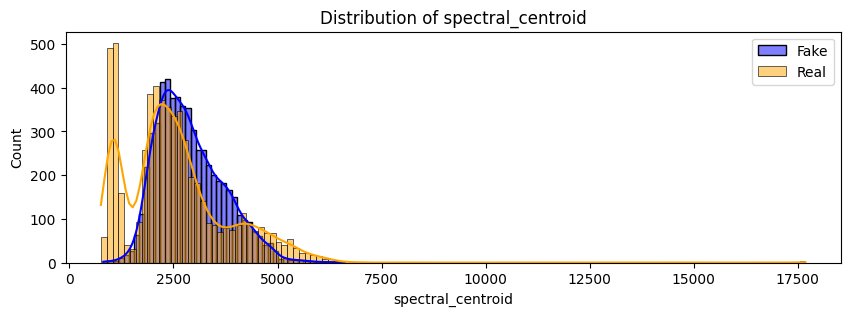

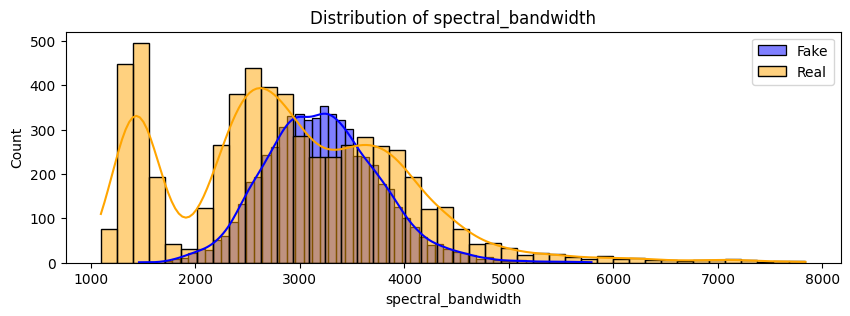

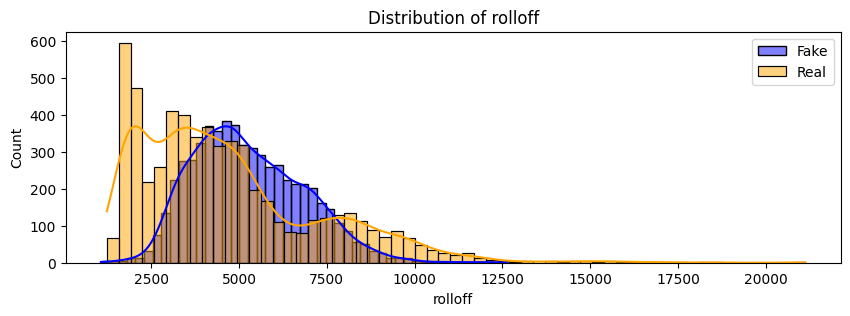

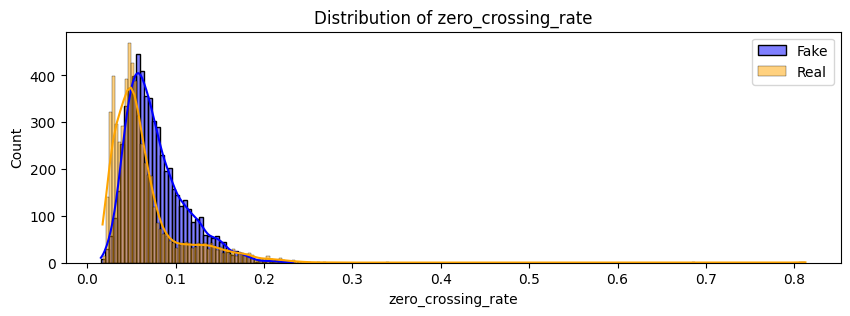

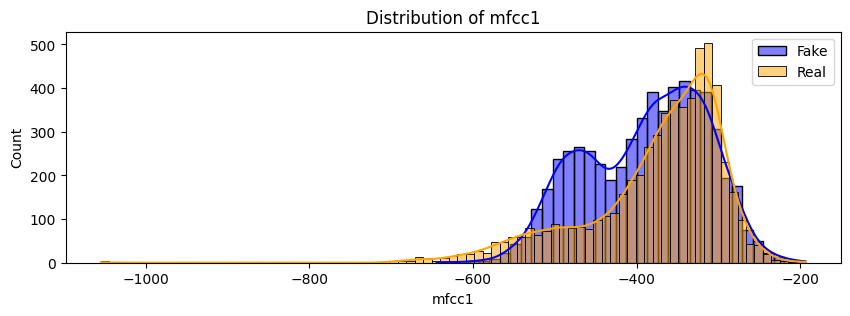

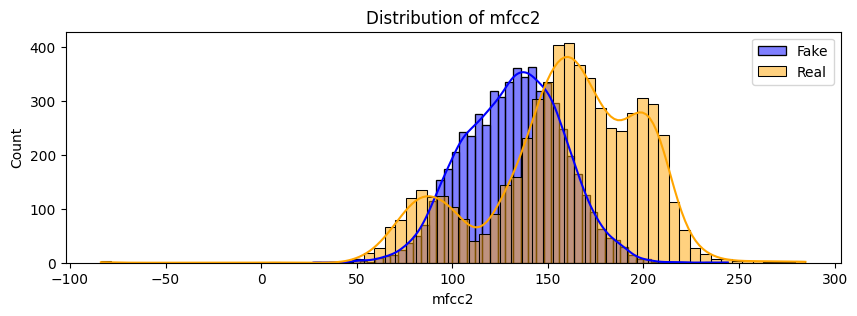

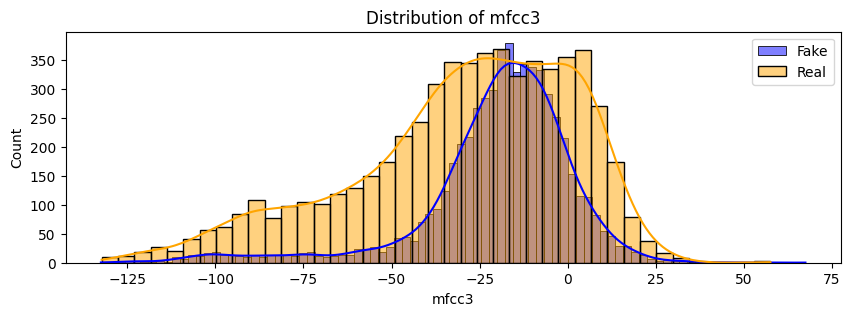

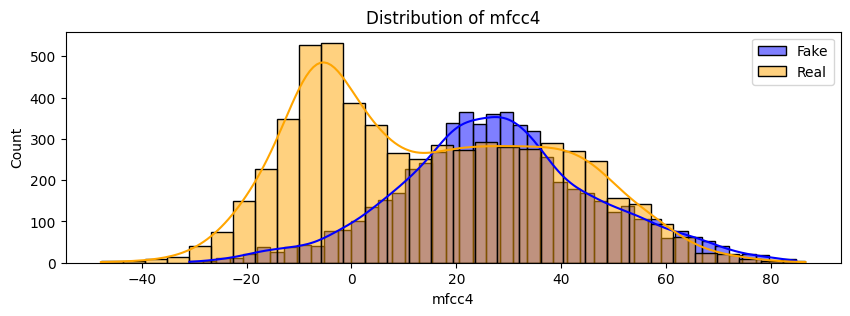

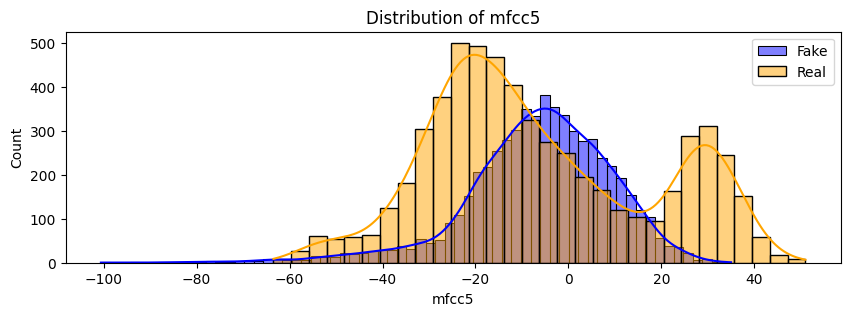

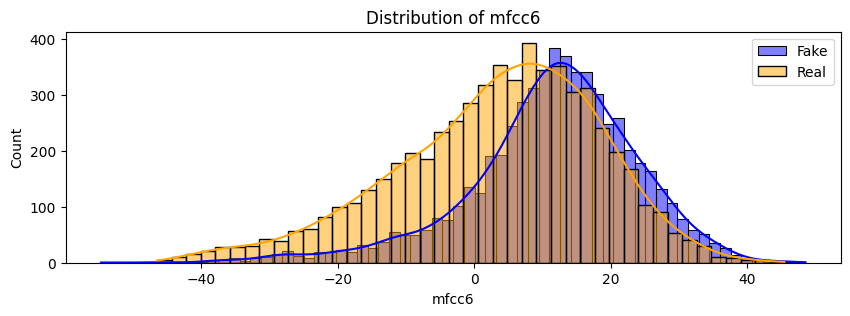

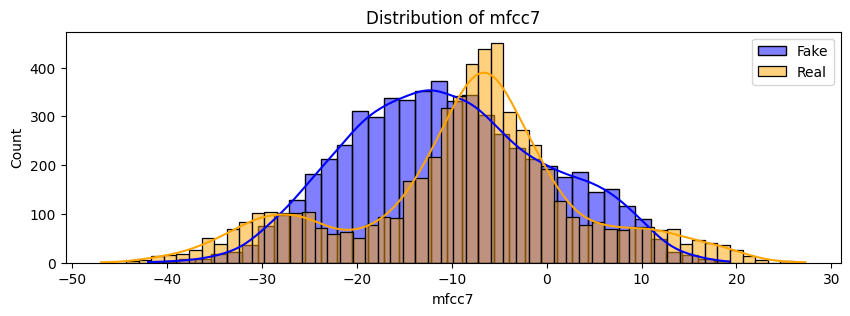

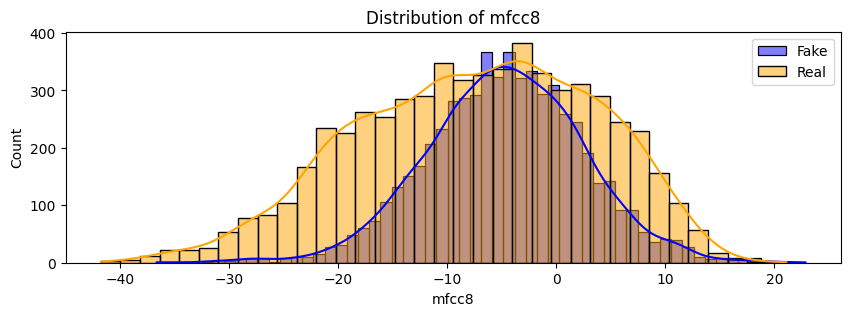

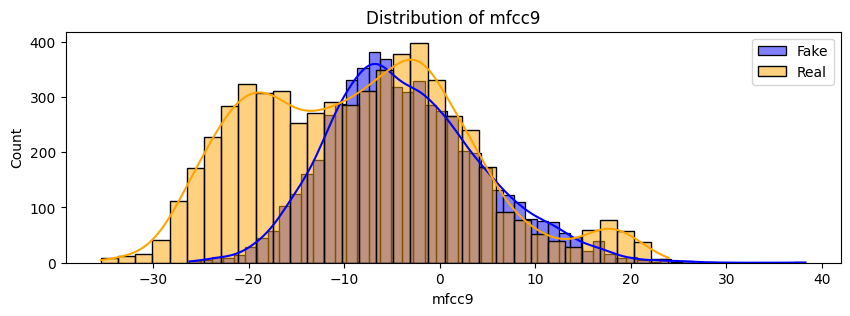

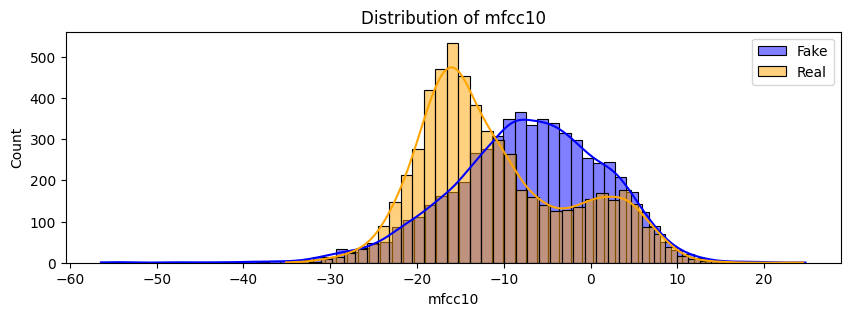

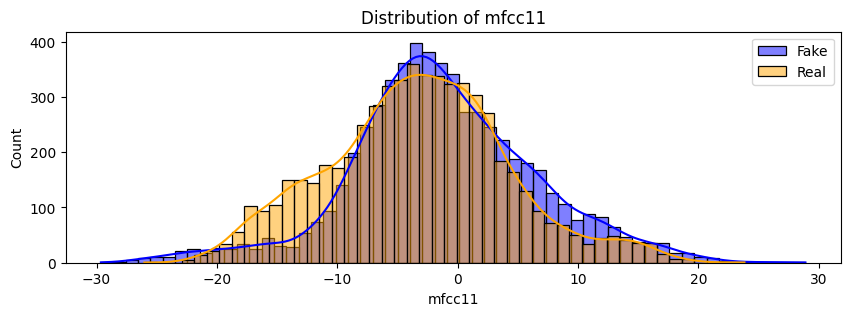

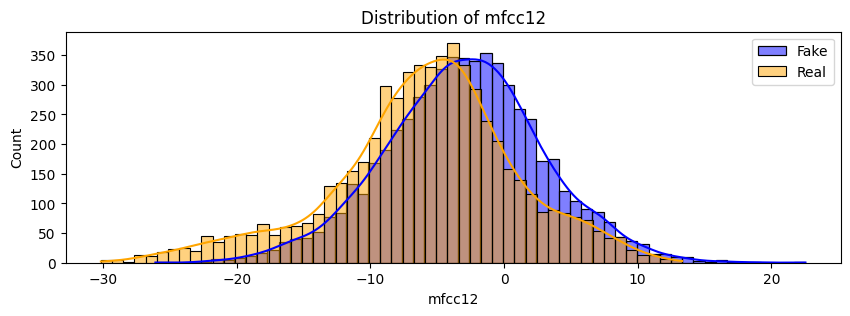

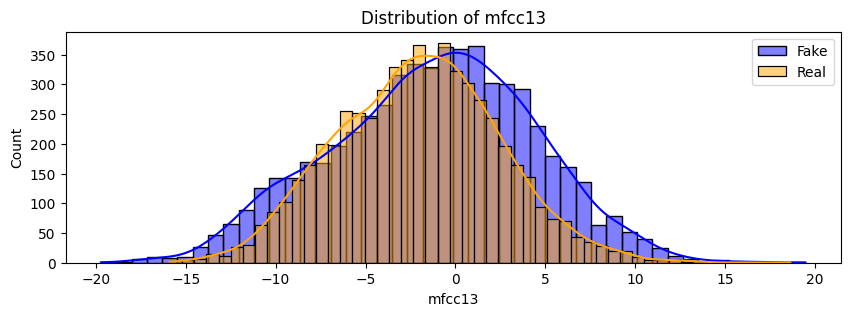

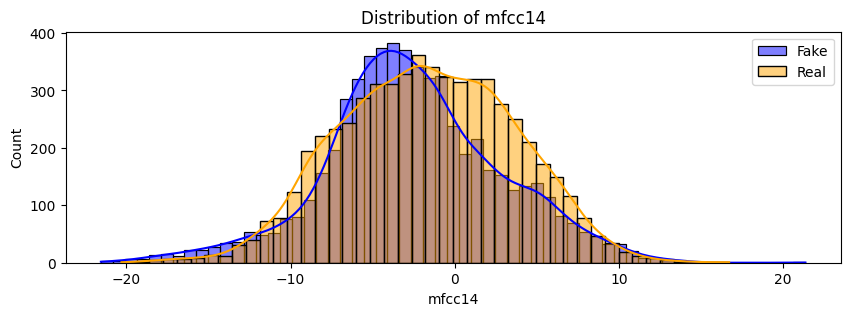

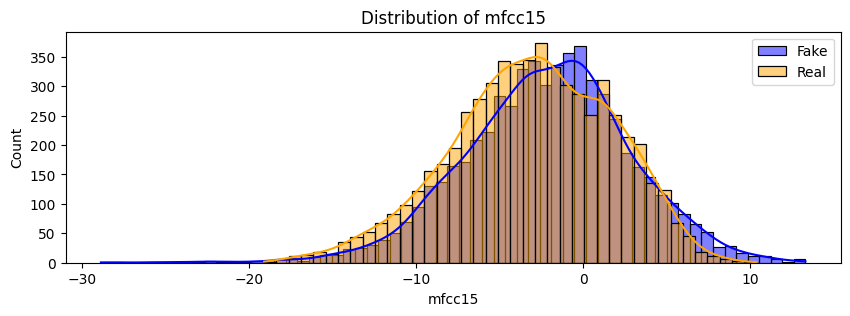

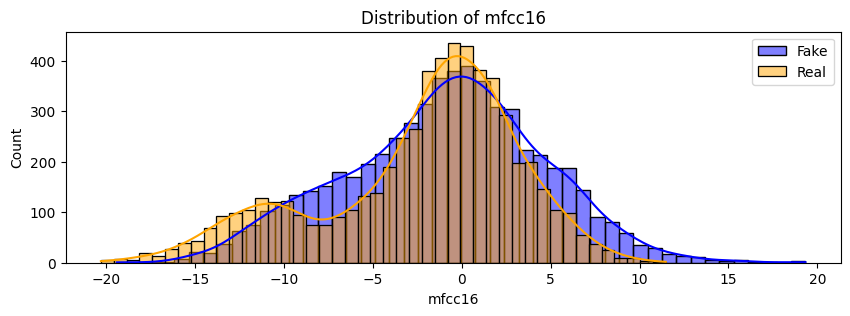

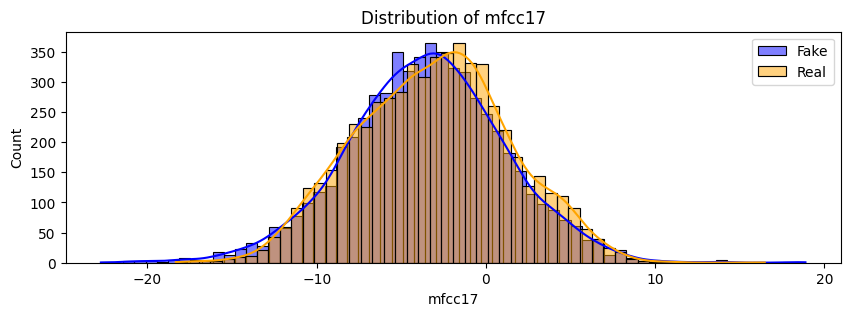

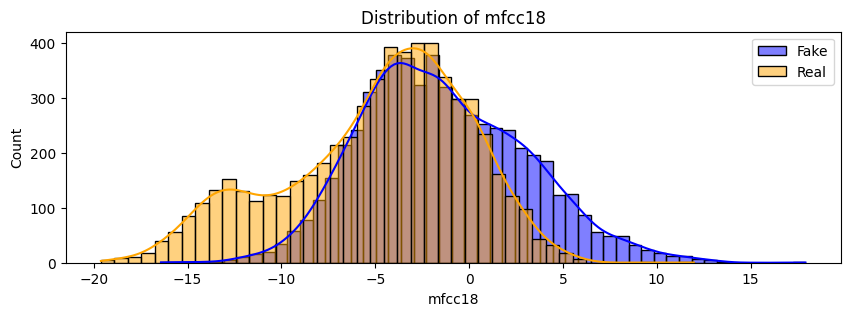

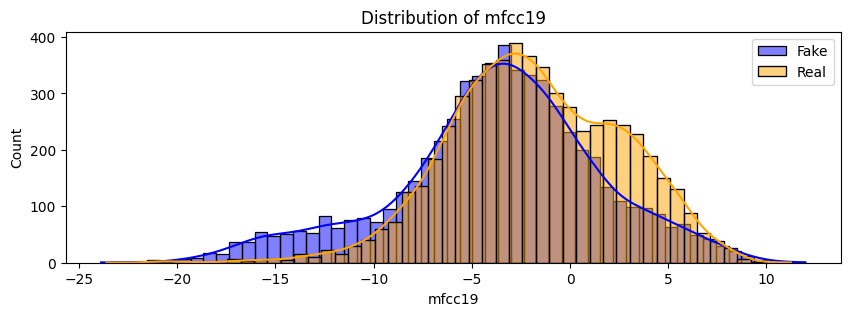

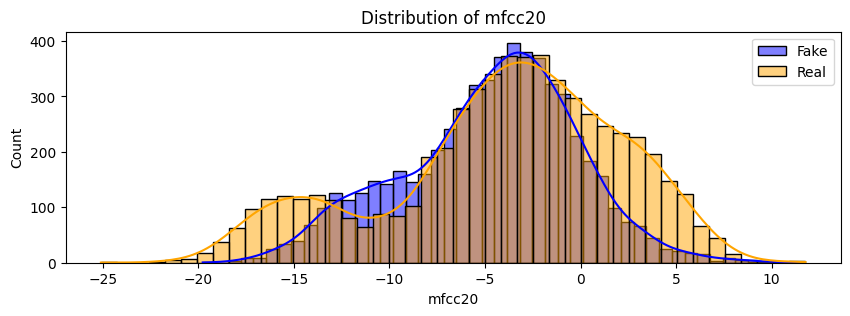

In [17]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
for column in X:
    plt.figure(figsize=(10, 3))
    sns.histplot(audio_data[audio_data['LABEL'] == 0][column], kde=True, label='Fake', color='blue')
    sns.histplot(audio_data[audio_data['LABEL'] == 1][column], kde=True, label='Real', color='orange')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

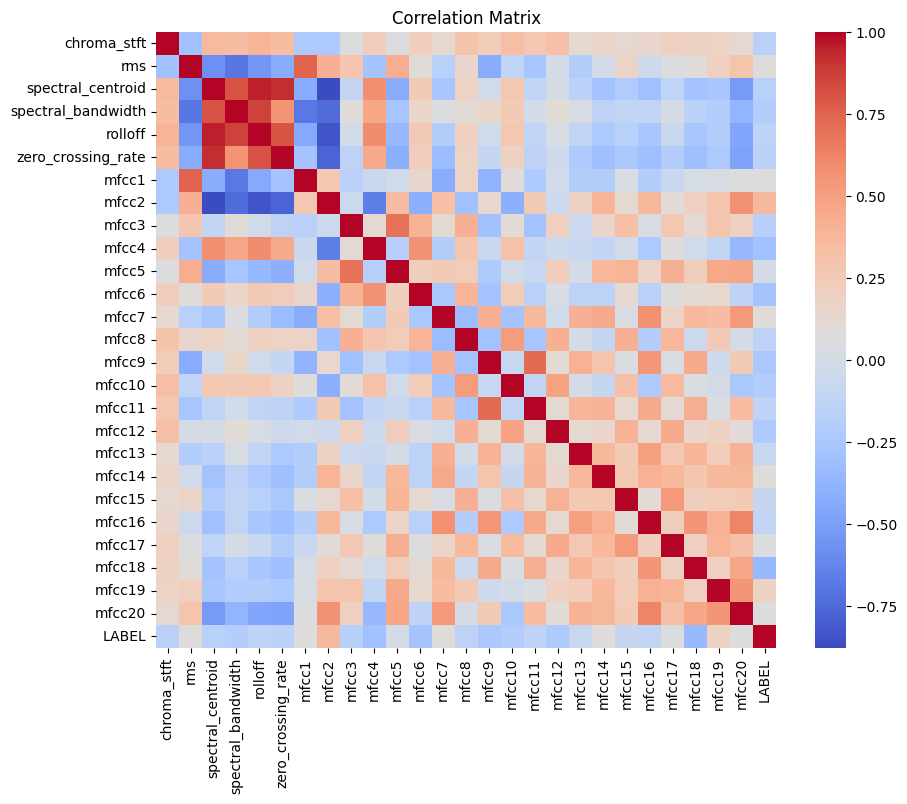

In [18]:
import seaborn as sns

correlation_matrix = audio_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# LSTM

In [19]:
X = X.values
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True ,random_state=42)

In [20]:
X_reshaped = np.zeros((X_train.shape[0], 17, 10))

for i in range(17):
    X_reshaped[:, i, :] = X_train[:, i:i + 10]

y_reshaped = np.reshape(y_train, (y_train.shape[0], 1))

X_train = X_reshaped
y_train = y_reshaped

In [21]:
X_test_reshaped = np.zeros((X_test.shape[0], 17, 10))

for i in range(17):
    X_test_reshaped[:, i, :] = X_test[:, i:i + 10]

y_test_reshaped = np.reshape(y_test, (y_test.shape[0], 1))

X_test = X_test_reshaped
y_test = y_test_reshaped

In [22]:
print(X_train.shape)
print(y_train.shape)

(9422, 17, 10)
(9422, 1)


In [24]:
model = Sequential()

model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss = BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 17, 64)            19200     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Epoch 1/20
295/295 [==============================] - 8s 6ms/step - loss: 0.5963 - accuracy: 0.6911
Epoch 2/20
295/295 [==============================] - 2s 6ms/step - loss: 0.3017 - accuracy: 0.8923
Epoch 3/20
295/295 [==============================] - 2s 6ms/step - loss: 0.1839 - accuracy: 0.9400
Epoch 4/20
295/295 [==============================] - 2s 6ms/step - loss: 0.1433 - accuracy: 0.9550
Epoch 5/20
295/295 [==============================] - 2s 6ms/step - loss: 0.1223 - accuracy: 0.9605
Epoch 6/20
295/295 [==============================] - 2s 6ms/step - loss: 0.1023 - accuracy: 0.9672
Epoch 7/20
295/295 [==============================] - 2s 6ms/step - loss: 0.0885 - accuracy: 0.9721
Epoch 8/20
295/295 [==============================] - 2s 6ms/step - loss: 0.0762 - accuracy: 0.9785
Epoch 9/20
295/295 [==============================] - 2s 6ms/step - loss: 0.0652 - accuracy: 0.9810
Epoch 10/20
295/295 [==============================] - 2s 6ms/step - loss: 0.0670 - accuracy: 0.9797

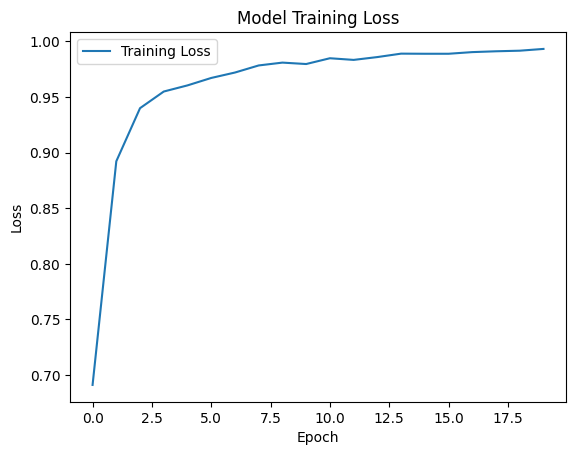

In [25]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20)

plt.plot(history.history['accuracy'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss'])
plt.show()


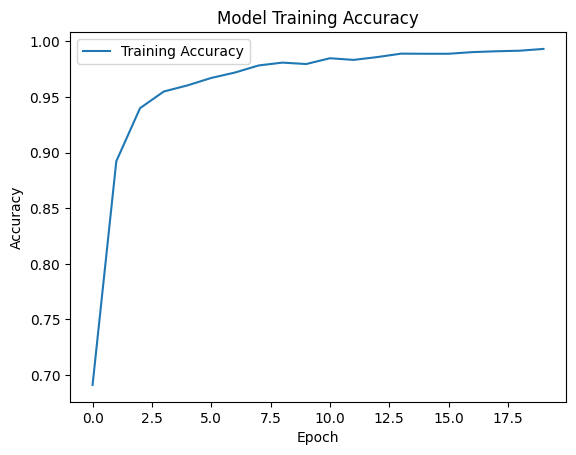

In [26]:
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy'])
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

74/74 [==============================] - 1s 3ms/step - loss: 0.0645 - accuracy: 0.9817
Test Loss: 0.06454017013311386
Test Accuracy: 0.9817487001419067


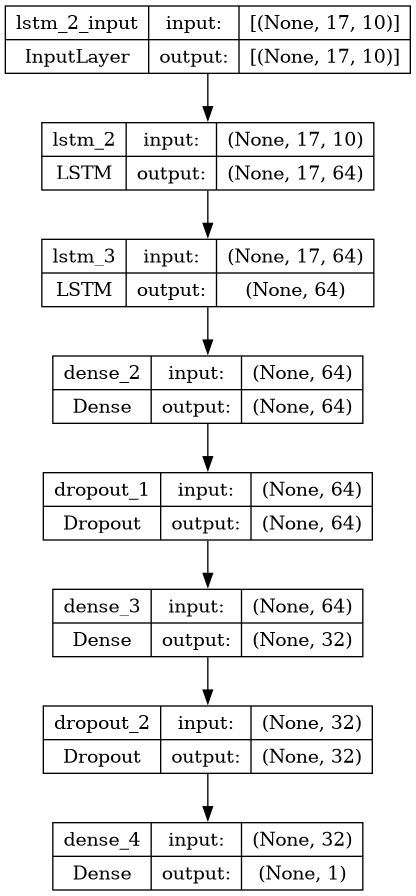

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='lstm_architecture.png', show_shapes=True, show_layer_names=True)

# WIRENET

In [29]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)
from sklearn.metrics import confusion_matrix
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [30]:
X_train,X_Test,Y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape[1]

26

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_Test)

X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

In [32]:
def WIRENetSpoofImprovedEnhanced(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)  # Increased dropout rate for regularization

    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(256, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)

    x = Conv1D(512, 3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (X_train_std.shape[1], 1)


def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.1
    return lr


model = WIRENetSpoofImprovedEnhanced(input_shape)

model.compile(
    optimizer=Adam(learning_rate=0.000001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    X_train_std,
    Y_train,
    epochs=20,
    batch_size=32)

Epoch 1/20
295/295 [==============================] - 12s 10ms/step - loss: 4.2528 - accuracy: 0.5160
Epoch 2/20
295/295 [==============================] - 3s 10ms/step - loss: 4.1881 - accuracy: 0.5503
Epoch 3/20
295/295 [==============================] - 3s 11ms/step - loss: 4.1392 - accuracy: 0.5827
Epoch 4/20
295/295 [==============================] - 3s 10ms/step - loss: 4.0921 - accuracy: 0.6107
Epoch 5/20
295/295 [==============================] - 3s 12ms/step - loss: 4.0601 - accuracy: 0.6192
Epoch 6/20
295/295 [==============================] - 3s 10ms/step - loss: 4.0335 - accuracy: 0.6423
Epoch 7/20
295/295 [==============================] - 3s 10ms/step - loss: 4.0003 - accuracy: 0.6640
Epoch 8/20
295/295 [==============================] - 3s 10ms/step - loss: 3.9677 - accuracy: 0.6801
Epoch 9/20
295/295 [==============================] - 3s 10ms/step - loss: 3.9386 - accuracy: 0.6909
Epoch 10/20
295/295 [==============================] - 3s 10ms/step - loss: 3.9183 - accur

In [33]:
test_loss, test_acc = model.evaluate(X_test_std, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

74/74 [==============================] - 1s 5ms/step - loss: 3.5323 - accuracy: 0.8659
Test Loss: 3.5323128700256348
Test Accuracy: 0.8658743500709534


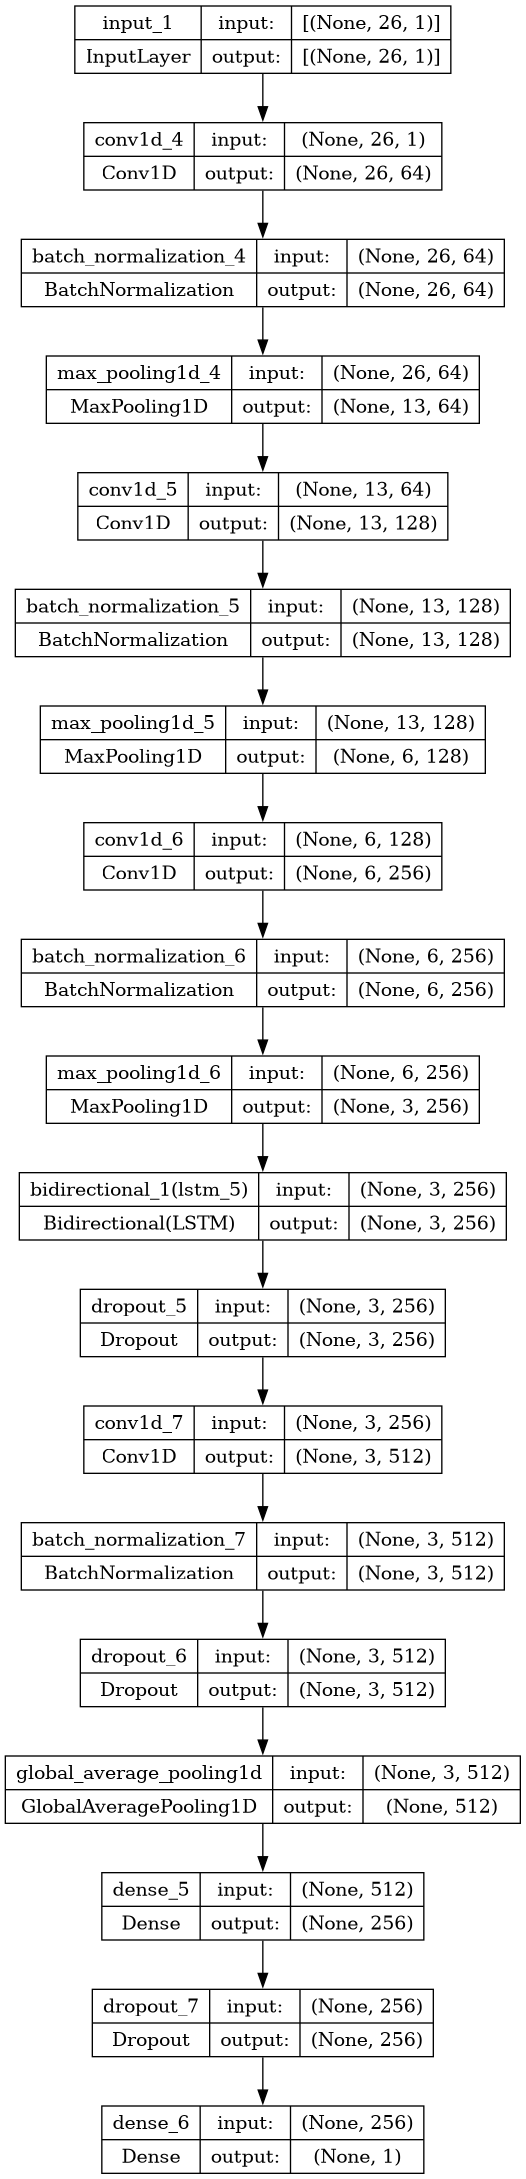

In [34]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='wirenet_architecture.png', show_shapes=True, show_layer_names=True)